In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow.keras as K
import numpy as np


input_tensor = K.Input(shape=(32, 32, 3))
(x_train, y_train), (x_test, y_test) = K.datasets.cifar10.load_data()
x_train = K.applications.inception_v3.preprocess_input(x_train)
y_train = K.utils.to_categorical(y_train, 10)
x_test = K.applications.inception_v3.preprocess_input(x_test)
y_test = K.utils.to_categorical(y_test, 10)

x_train = np.concatenate((x_train, np.flip(x_train, 2)), 0)
y_train = np.concatenate((y_train, y_train), 0)

input_tensor_resize = K.layers.Lambda(lambda image: K.backend.resize_images(
        image, (int(100/32)), (int(100/32)), "channels_last"))(input_tensor)

y = K.layers.ZeroPadding2D(padding=4)(input_tensor_resize)

pre_trained_model = K.applications.InceptionV3(
                            include_top=False,
                            weights="imagenet",
                            input_tensor=y,
                        )

    
#last_layer = pre_trained_model.get_layer('mixed7')
#last_output = last_layer.output

# Flatten the output layer to 1 dimension
# x = K.layers.GlobalAveragePooling2D()(model.output)
x= K.layers.Flatten()(pre_trained_model.output)
#x= K.layers.BatchNormalization()(x)
# Add a fully connected layer with 256 hidden units and ReLU activation
x = K.layers.Dense(1024, activation='relu')(x)
x = K.layers.Dense(512, activation='relu')(x)
x = K.layers.Dense(256, activation='relu')(x)
# Add a dropout rate of 0.2
x = K.layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = K.layers.Dense(10, activation='softmax')(x)           

model = K.models.Model(pre_trained_model.input, x) 

lrr = K.callbacks.ReduceLROnPlateau(
                                   monitor='val_acc',
                                   factor=.01,
                                   patience=3,
                                   min_lr=1e-5)

es = K.callbacks.EarlyStopping(monitor='val_acc',
                               mode='max',
                               verbose=1,
                               patience=10)

mc = K.callbacks.ModelCheckpoint('cifar10.h5',
                                 monitor='val_acc',
                                 mode='max',
                                 verbose=1,
                                 save_best_only=True)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])


# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = K.preprocessing.image.ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow(x_train, y_train, batch_size = 20)     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow(x_test, y_test, batch_size = 20)



history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=128,
                    callbacks=[es, mc, lrr],
                    epochs=20,
                    verbose=1)

model.save('cifar10.h5')

87916544/87910968 [==============================] - 1s 0us/step
Epoch 1/20
782/782 [==============================] - ETA: 0s - loss: 0.9440 - acc: 0.6769
Epoch 00001: val_acc improved from -inf to 0.72510, saving model to cifar10.h5
782/782 [==============================] - 102s 131ms/step - loss: 0.9440 - acc: 0.6769 - val_loss: 3.7229 - val_acc: 0.7251 - lr: 0.0010
Epoch 2/20
782/782 [==============================] - ETA: 0s - loss: 0.5381 - acc: 0.8294
Epoch 00002: val_acc improved from 0.72510 to 0.81480, saving model to cifar10.h5
782/782 [==============================] - 100s 128ms/step - loss: 0.5381 - acc: 0.8294 - val_loss: 0.5739 - val_acc: 0.8148 - lr: 0.0010
Epoch 3/20
782/782 [==============================] - ETA: 0s - loss: 0.3664 - acc: 0.8842
Epoch 00003: val_acc improved from 0.81480 to 0.86440, saving model to cifar10.h5
782/782 [==============================] - 100s 128ms/step - loss: 0.3664 - acc: 0.8842 - val_loss: 0.4204 - val_acc: 0.8644 - lr: 0.0010
Epoch

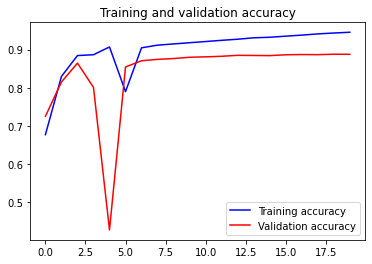

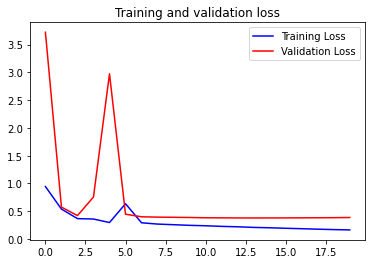

In [3]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()